Import some packages


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt

Load data from local


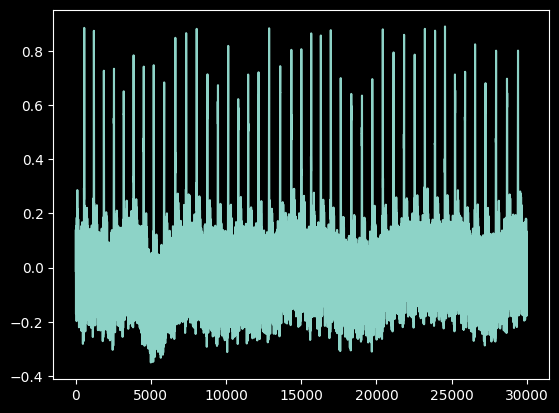

In [3]:
input = np.loadtxt("data/ECG_1000Hz_7.dat")
plt.plot(input)
plt.show()

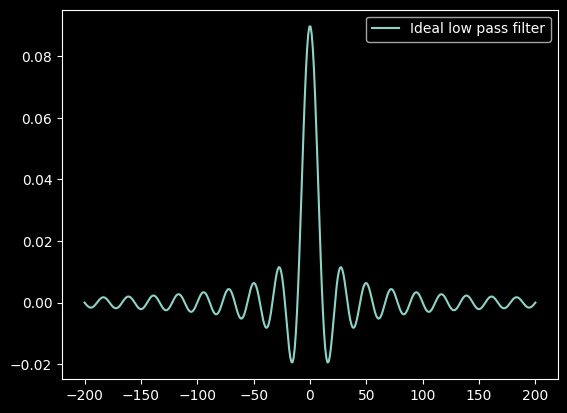

In [4]:
x = np.linspace(-200, 200, 400)
y = 1/(np.pi * x)*np.sin(45/500*np.pi * x)
plt.plot(x, y, label=r"Ideal low pass filter")
plt.legend()
plt.show()

In [5]:
def highpassDesign(sample, high_frequency, frequency_resulotion):
    M = int(sample / frequency_resulotion)
    ideal_filter = np.zeros(M)
    highband = int(high_frequency/sample * M)
    ideal_filter[highband:M-highband+1] = 1
    ideal_filter = np.fft.ifft(ideal_filter).real
    highpass_filter = np.empty(M)
    highpass_filter[0:int(M/2)] = ideal_filter[int(M/2):M]
    highpass_filter[int(M/2):M] = ideal_filter[0:int(M/2)]
    highpass_filter = highpass_filter * np.hamming(M)
    return highpass_filter

def bandstopDesign(sample, low_frequency, high_frequency, frequency_resulotion):
    M = int(sample / frequency_resulotion)
    ideal_filter = np.ones(M)
    low_band = int(low_frequency/sample * M)
    high_band = int(high_frequency/sample * M)
    ideal_filter[low_band:high_band+1] = 0
    ideal_filter[M-high_band:M-low_band+1] = 0
    ideal_filter = np.fft.ifft(ideal_filter).real
    bandstop_filter = np.empty(M)
    bandstop_filter[0:int(M/2)] = ideal_filter[int(M/2):M]
    bandstop_filter[int(M/2):M] = ideal_filter[0:int(M/2)]
    bandstop_filter = bandstop_filter * np.hamming(M)
    return bandstop_filter

highpassDesign(1000, 50, 0.5)

array([4.00000000e-05, 3.80627579e-05, 3.24382283e-05, ...,
       2.36665959e-05, 3.24354645e-05, 3.80616768e-05])

In [6]:
class FIRFilter:
    def __init__(self, _coefficients:list):
        self.coefficients_list = [_coefficients]
        self.real_coefficients = _coefficients
        self.coefficients_length = len(self.real_coefficients)
        self.buffer = np.zeros(self.coefficients_length)

    def add_coefficients(self, _coefficients:list):
        self.coefficients_list.append(_coefficients)

    def synthesis(self):
        if len(self.coefficients_list) == 1:
            return
        tmp = self.coefficients_list[0]
        for coeff in self.coefficients_list[1::]:
            tmp = self.convolution(coeff, tmp)
        self.real_coefficients = tmp
        self.coefficients_length = len(self.real_coefficients)
        self.buffer = np.zeros(self.coefficients_length)


    def convolution(self, x_1:list, x_2:list):
        n = len(x_1)
        m = len(x_2)
        x_1 = np.array(x_1)
        x_2 = np.array(x_2)
        tmp = np.zeros(2*n+m)
        tmp[n-1:n+m-1] = x_2
        result = np.empty(m+n-1)
        for i in range(0, m+n-1):
            result[i] = np.dot(x_1, tmp[i:i+n][::-1])
        return result


    def dofilter(self, v):
        # Shift values in the buffer
        self.buffer[1:] = self.buffer[:-1]
        self.buffer[0] = v

        # Apply the filter
        result = np.dot(self.real_coefficients, self.buffer)

        return result

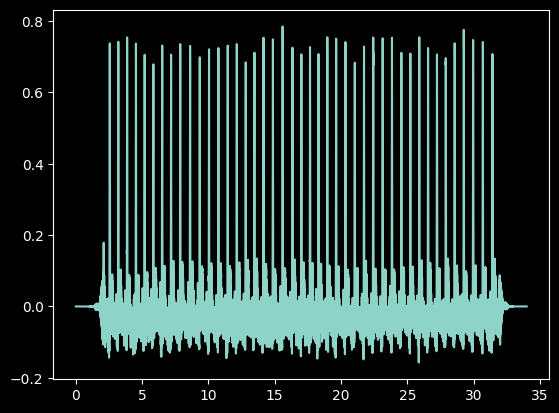

In [7]:
coeff_highpass = highpassDesign(1000, 1, 0.5)
coeff_bandstop = bandstopDesign(1000, 49, 51, 0.5)


filter = FIRFilter(coeff_highpass)
filter.add_coefficients(coeff_bandstop)
filter.synthesis()

new_signal = np.zeros(len(input)+filter.coefficients_length-1)

for i in range(0, len(input)+filter.coefficients_length-1):
    if i < len(input):
        new_signal[i] = filter.dofilter(input[i])
    else:
        new_signal[i] = filter.dofilter(0)

time = np.arange(0, len(new_signal)) / 1000
plt.plot(time, new_signal)
plt.show()

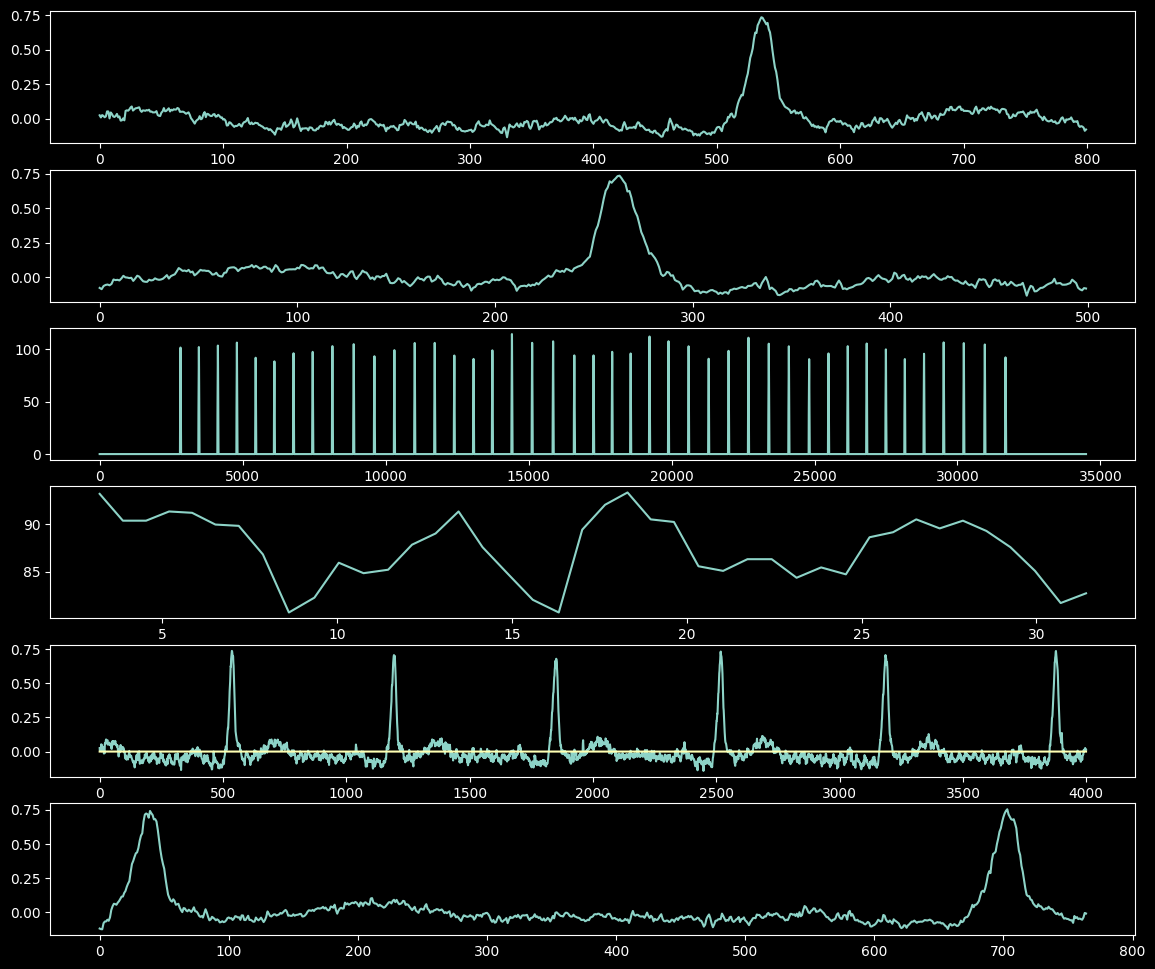

In [15]:
plt.figure(figsize=(14, 12))
plt.subplot(6,1,1)
plt.plot(new_signal[4000:4800])
template = new_signal[4300:4800]
np.savetxt("data/ECG_template_1000Hz.dat", template)
fir_coeff = template[::-1]
plt.subplot(6,1,2)
plt.plot(fir_coeff)
matched_filter = FIRFilter(fir_coeff)

detect_signal = np.zeros(len(new_signal)+matched_filter.coefficients_length-1)
highest_point = 0
need_addition = False
peak = []
orign_peak = []
signal_peak = []
heart_rate = []
heart_time = []

for i in range(0, len(new_signal)+matched_filter.coefficients_length-1):
    if i < len(new_signal):
        if new_signal[highest_point] < new_signal[i]:
            highest_point = i
            if need_addition:
                orign_peak.append(highest_point)
                highest_point = 0
                need_addition = False
        detect_signal[i] = matched_filter.dofilter(new_signal[i])**2
    else:
        detect_signal[i] = matched_filter.dofilter(0)**2
    if detect_signal[i] < 20:
        detect_signal[i] = 0
    else:
        peak.append(i)

    if len(peak) >= 3 and detect_signal[peak[-2]] > detect_signal[peak[-3]] and detect_signal[peak[-2]] > detect_signal[peak[-1]]:
        signal_peak.append(int(peak[-2]-(matched_filter.coefficients_length-1)/2))
        if np.abs(signal_peak[-1] - highest_point) > 300:
            need_addition = True
        else:
            orign_peak.append(highest_point)
            highest_point = 0
        if len(orign_peak)>1:
            heart_rate.append(60 /((orign_peak[-1]-orign_peak[-2])/1000))
            heart_time.append(orign_peak[-1]/1000)
plt.subplot(6,1,3)
plt.plot(detect_signal)

plt.subplot(6,1,4)
plt.plot(heart_time,heart_rate)

plt.subplot(6,1,5)
plt.plot(new_signal[4000:8000])
plt.plot(np.zeros(4000))
#plt.plot(orign_peak, new_signal[orign_peak], 'ro')

plt.subplot(6,1,6)
plt.plot(new_signal[signal_peak[1]-50:signal_peak[2]+50])

plt.show()
